<a href="https://colab.research.google.com/github/EugenHotaj/pytorch-generative/blob/master/notebooks/__draft__gaussian_processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, spatial

In [172]:
def sausage_plot(X, Y=None, mu_sig=None, fn=None, obs=None):
    """Creates a sausage plot of a 1D Gaussian process. 

    Args:
        X: (n x 1) array containing the x-axis coordinates.
        Y: (n x k) array containing k samples drawn from the Gaussian process at X.
        mu_sig: Tuple of (n x 1) arrays containing the marginal (means, stds) at X. If
            provided the means and 95% credible intervals are plotted.
        fn: True (noiseless) function being modeled by the Gaussian process. If 
            provided, fn(X) is plotted.
        obs: Tuple of (possibly noisy) observations from the true function.
    """
    assert any([Y is not None, mu_sig is not None, fn is not None])

    fig = plt.figure(figsize=(20, 4))
    y_max = []
 
    # Plot samples.
    if Y is not None:
        for i in range(Y.shape[0]): 
            sample = Y[i, :]
            plt.plot(X, sample, color="tab:orange")
            y_max.append(sample)

    # Plot mean and credible intervals.
    if mu_sig is not None:
        mu, sigma = mu_sig
        lower_bound, upper_bound = mu - 1.96 * sigma, mu + 1.96 * sigma
        plt.fill_between(X, lower_bound, upper_bound, facecolor='lightblue')
        plt.plot(X, mu, c="tab:blue")
        y_max.extend([lower_bound, upper_bound, mu])

    # Plot the true function.
    if fn is not None:
        Y = fn(X)
        plt.plot(X, Y, color="tab:red", linestyle="dashed")
        y_max.append(Y)

    # Plot observations.
    if obs is not None:
        plt.scatter(*obs, color="tab:red")
        y_max.append(obs[1])

    # Set axis limits.
    plt.xlim(X.min(), X.max())
    y_max = max([np.abs(y).max() for y in y_max])
    plt.ylim(-y_max - .5, y_max + .5)

    plt.show()

In [175]:
class GaussianProcess:
    def __init__(self, mean_fn, cov_fn, noise_obs=0.0):
        self.mean_fn = mean_fn
        self.cov_fn = cov_fn
        self.noise_obs = noise_obs
        self.x_obs = []
        self.y_obs = []

    def fit(self, x, y):
        self.x_obs.append(x)
        self.y_obs.append(y)

    def _sample(self, mu, sigma, n_samples):
        return np.random.multivariate_normal(mu, sigma, size=n_samples)

    def _sample_prior(self, x, n_samples):
        mu = self.mean_fn(x).reshape(-1)
        sigma = self.cov_fn(x, x)
        samples = self._sample(mu, sigma, n_samples)
        return mu, sigma, samples

    def sample(self, x, n_samples=1):
        if not self.x_obs:
            return self._sample_prior(x, n_samples)

        # Compute means and covariances.
        x_obs, y_obs = np.stack(self.x_obs), np.stack(self.y_obs)
        mu_obs, mu_x = self.mean_fn(x_obs), self.mean_fn(x)
        sigma_obs = self.cov_fn(x_obs, x_obs) + self.noise_obs * np.eye(x_obs.shape[0])
        sigma_x = self.cov_fn(x, x)
        sigma_obs_x = self.cov_fn(x_obs, x)

        # Compute posterior mean and covariance.
        solved = linalg.solve(sigma_obs, sigma_obs_x, assume_a="pos").T 
        mu = (solved @ y_obs).flatten()
        sigma = sigma_x - (solved @ sigma_obs_x)
        samples = self._sample(mu, sigma, n_samples)

        return mu, sigma, samples

In [179]:
domain = -6, 6
n_grid = 100
n_train = 5
n_samples = 4
noise = 0.1

def f(x, noise=0.):
    y = np.sin(x) 
    if noise:
        y += np.random.normal(size=x.shape) * noise
    return y

grid_x = np.linspace(*domain, n_grid)
train_x = np.random.uniform(*domain, size=(n_train, 1))
train_y = f(train_x, noise)

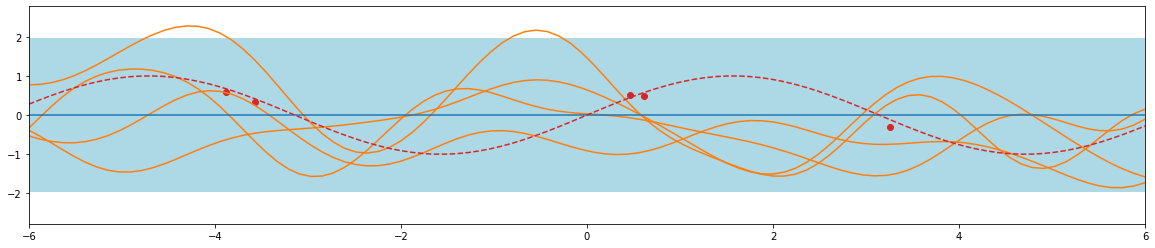

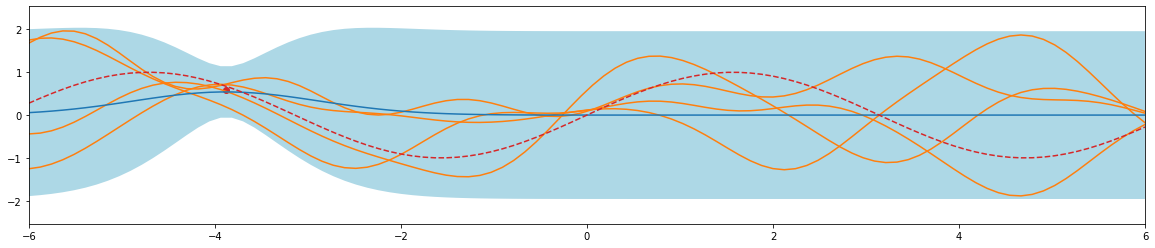

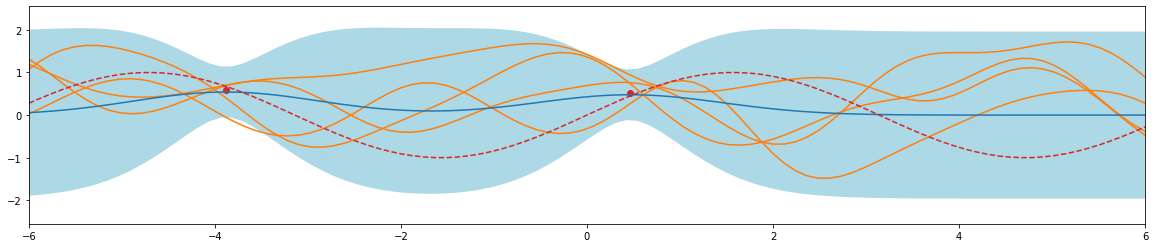

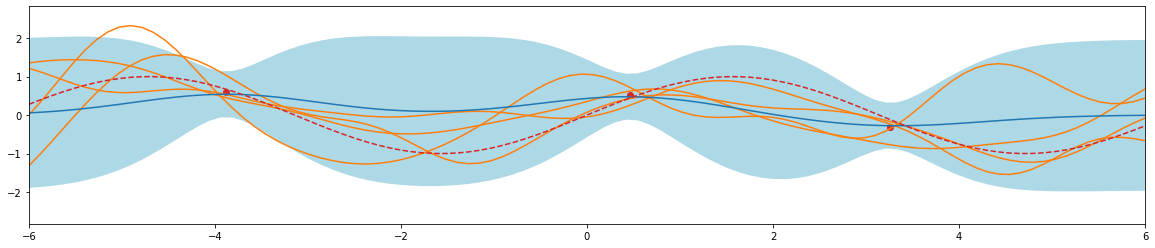

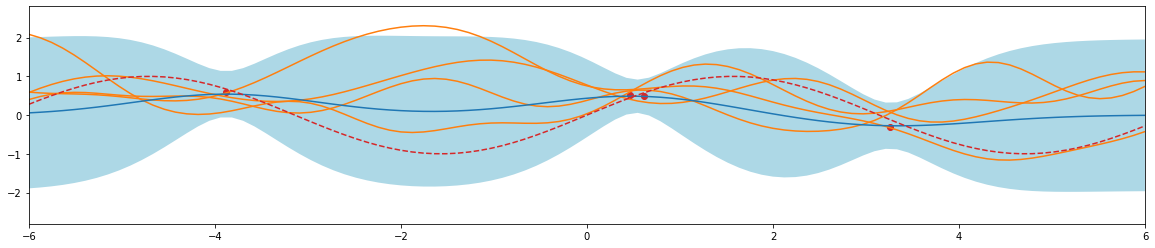

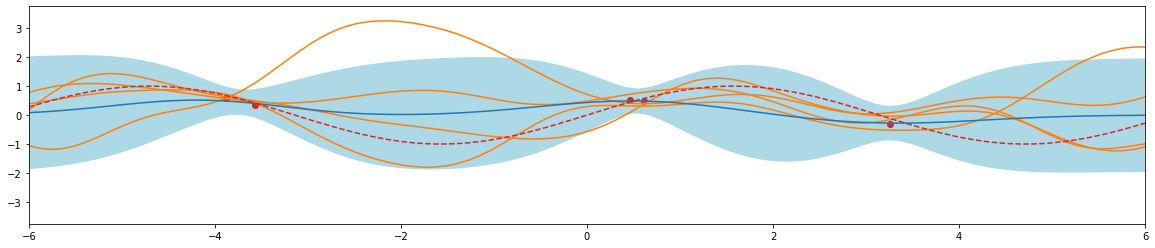

In [180]:
mean_fn = np.zeros_like

def cov_fn(left, right):
    left, right = left.reshape(-1, 1), right.reshape(-1, 1)
    return np.exp(-.5 * spatial.distance.cdist(left, right, 'cityblock')**2)

gp = GaussianProcess(mean_fn, cov_fn, noise)

# Sample from prior.
mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
sausage_plot(grid_x, samples, (mu, np.sqrt(np.diag(sigma))), f, (train_x, train_y))

# Sample from posterior.
for i in range(len(train_x)):
    gp.fit(train_x[i], train_y[i])
    mu, sigma, samples = gp.sample(grid_x.reshape(-1, 1), n_samples)
    sausage_plot(
        grid_x, 
        samples, 
        (mu, np.sqrt(np.diag(sigma))), 
        f, 
        (train_x[:(i+1)], train_y[:(i+1)]),
    )